In [33]:
import os
from PIL import Image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F
from torchvision import transforms as transforms

from imgseg import show

In [40]:
SHOW_N = 4
path = './ct_data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
images = np.random.choice(os.listdir(path), SHOW_N)
images = [os.path.join(path, img) for img in images]
images = [Image.open(p) for p in images]
images = [transforms.ToTensor()(img) for img in images]

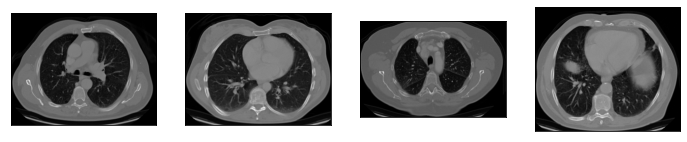

In [41]:
show(images)